In [19]:
import torch # to create tensors to store the raw data, weights and biases 
import torch.nn as nn # to make the weights and biases learnable (part of the network)
import torch.nn.functional as F # to apply activation functions 
from torch.optim import SGD # stochastic gradient descent 

import lightning as L # to train the model 
from torch.utils.data import DataLoader, TensorDataset # to load the data 
from lightning.pytorch.tuner.tuning import Tuner      
from lightning.pytorch.callbacks import ModelCheckpoint #Lightning is trying to delete the previous checkpoint (because the default ModelCheckpoint is set to save_top_k=1).
                                                        # On Windows a file gets locked as soon as any program (Explorer preview, antivirus, TensorBoard, VS Code, …) opens it, and Windows then blocks the delete call ⇒ PermissionError WinError 32.

import matplotlib.pyplot as plt # graphs 
import seaborn as sns # graphs


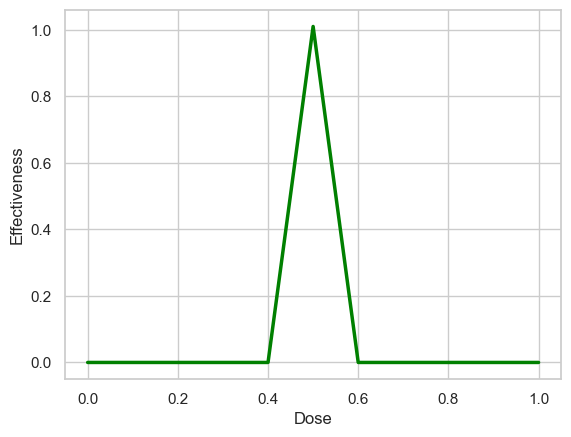

In [20]:
class BasicLightning(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.w00=nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00=nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01=nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10=nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10=nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11=nn.Parameter(torch.tensor(2.7), requires_grad=False)
        
        self.final_bias=nn.Parameter(torch.tensor(-16.), requires_grad=False)
    
    def forward(self, input): # define the forward pass of the network
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output =  F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)
        return output

model=BasicLightning()

input_values= torch.linspace(start=0, end=1, steps=11)
output_values=model(input_values)

sns.set_theme(style="whitegrid")
sns.lineplot(x=input_values,y=output_values, color="green", linewidth=2.5)
plt.ylabel("Effectiveness")
plt.xlabel("Dose")
plt.show()



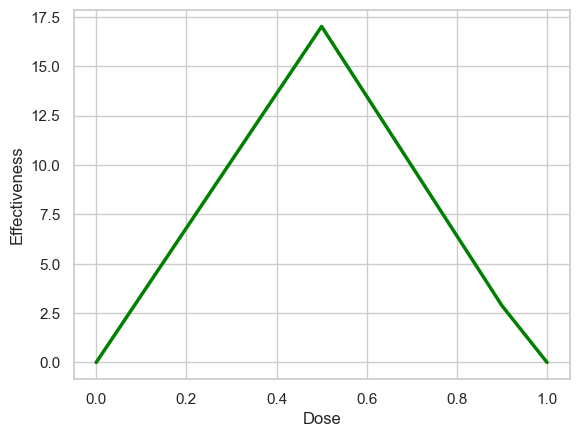

In [23]:
class BasicLightningTrain(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.w00=nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00=nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01=nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10=nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10=nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11=nn.Parameter(torch.tensor(2.7), requires_grad=False)
        
        self.final_bias=nn.Parameter(torch.tensor(0.0), requires_grad=True)

        self.learning_rate=0.01
    
    def forward(self, input): # define the forward pass of the network
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output =  F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)

        return output

    def configure_optimizers(self):
        return SGD(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)

        loss = (output_i-label_i)**2

        return loss

model=BasicLightningTrain()

input_values= torch.linspace(start=0, end=1, steps=11)
output_values=model(input_values)

sns.set_theme(style="whitegrid")
sns.lineplot(x=input_values,y=output_values.detach(), color="green", linewidth=2.5)
plt.ylabel("Effectiveness")
plt.xlabel("Dose")
plt.show()


In [78]:
inputs= torch.tensor([0.,0.5,1.])
labels= torch.tensor([0.,1.,0.])
'''
Data Loaders are useful when we have a lot of data cuz:
- They allow us to load data in batches
- They allow us to shuffle the data
- They allow us to load data in parallel
- They allow us to use small fractions of data when we want to do a quick or dirty training for debugging 
'''
dataset= TensorDataset(inputs, labels)
dataloader= DataLoader(dataset)

# this would create by default a 100 candidate learning rates and test them all cuz we have early stopping to None
ckpt_cb = ModelCheckpoint(save_top_k=-1)   # -1 = keep everything
trainer = L.Trainer(max_epochs=34, callbacks=[ckpt_cb])

tuner = Tuner(trainer)    # wrap the trainer

lr_find_results = tuner.lr_find(
        model,
        train_dataloaders=dataloader,
        min_lr=1e-3,
        max_lr=1.0,
        early_stop_threshold=None,
)

new_lr = lr_find_results.suggestion()

print("Recommended LR:", new_lr)

trainer.fit(model, train_dataloaders=dataloader) # the trainer starts by calling the configuer_optimizers() function in the model then it auto calls the zero_grad() function and the loss.backward() function and then it calls the optimizer.step() function and then it calls the models training_step() function
                                                # that is way simpler and easier than using PyTorch alone, it removes the loops and the all the chunks of code we needed before to do the training

print(model.final_bias.data)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=100` reached.
Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 1410.41it/s]
Learning rate set to 0.002137962089502232
Restoring states from the checkpoint path at c:\Users\dell\Deep-Learning-using-PyTorch\.lr_find_a83c5682-64a9-4cf6-b17e-f5aa97be8412.ckpt
Restored all states from the checkpoint at c:\Users\dell\Deep-Learning-using-PyTorch\.lr_find_a83c5682-64a9-4cf6-b17e-f5aa97be8412.ckpt

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Recommended LR: 0.002137962089502232
Epoch 33: 100%|██████████| 3/3 [00:00<00:00, 288.49it/s, v_num=58]

`Trainer.fit` stopped: `max_epochs=34` reached.


Epoch 33: 100%|██████████| 3/3 [00:00<00:00, 173.45it/s, v_num=58]
tensor(-16.0047)


if we want to scale the project we would to take it in a env with multi GPUs but if we do that using PyTorch alone we would have to manually change the code to move the tensors from the CPU to each GPUs but if we're using Lightning we can do it easily and automatically by putting this 
  **trainer = L.Trainer(max_epochs=34, accelerator='auto', devices="auto")**
it will determine if GPUs are available and how many GPUs used and it will automatically create the trainer objects in the GPUs